In [1]:
pip install opencv-python-headless matplotlib

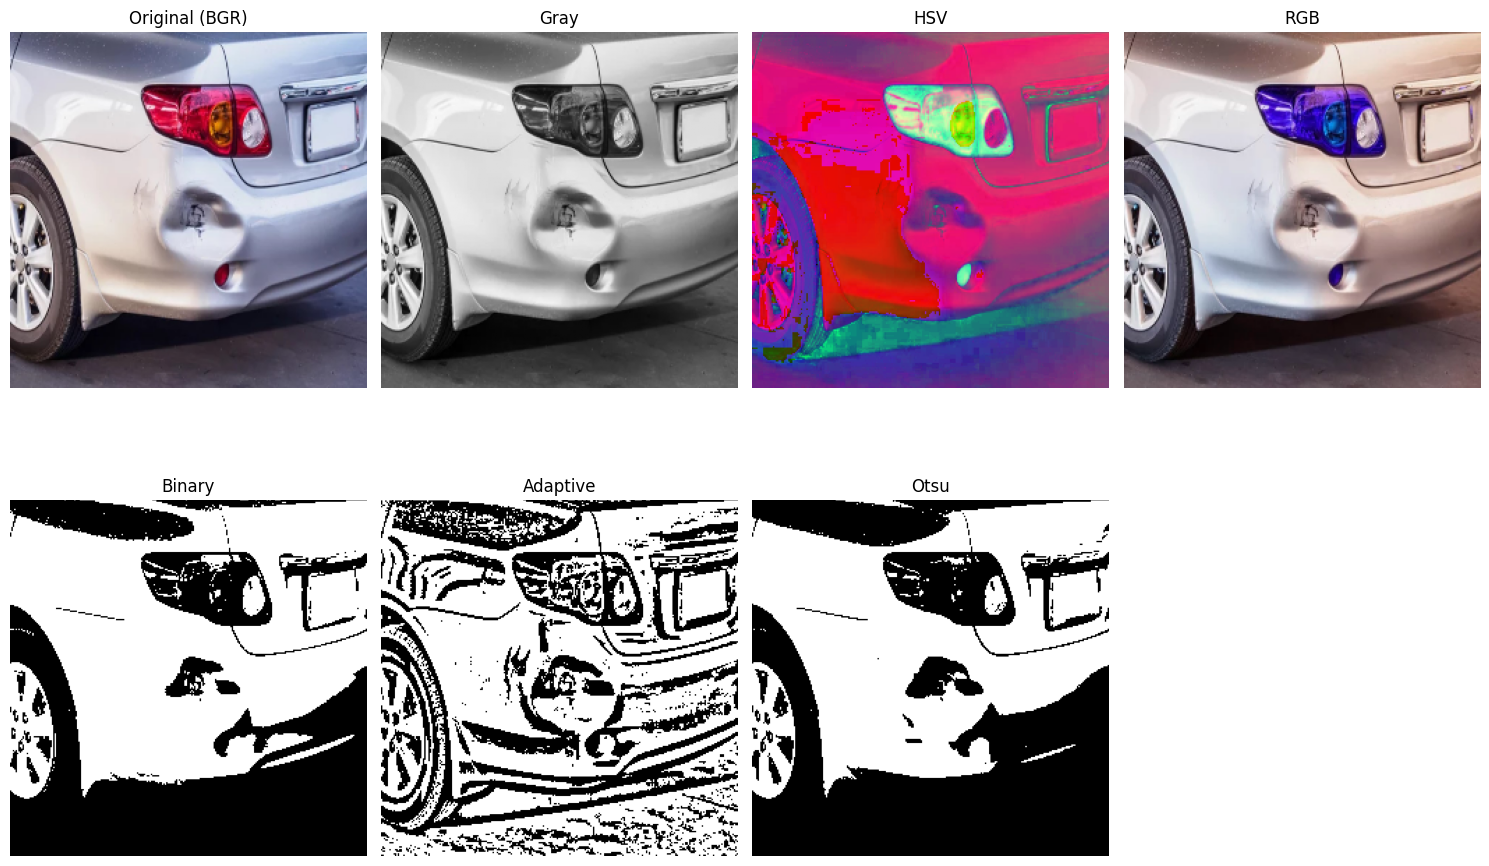

✅ Accurate damage area detected:
→ Height: 215 px
→ Width: 256 px


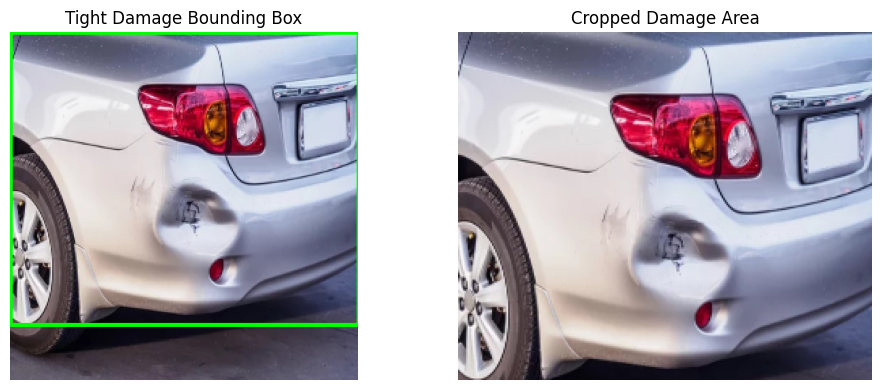

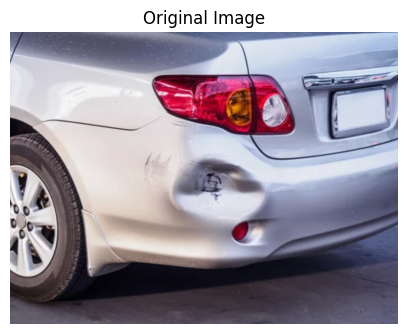

In [2]:
# 📌 Import required packages
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = '/content/car1.jpg'
img = cv2.imread(img_path)

# Check if image is loaded correctly
if img is None:
    raise FileNotFoundError(f"❌ Image not found at path: {img_path}")

# 📌 Resize image
def resize_image(img, size=(256, 256)):
    return cv2.resize(img, size)

# 📌 Convert color spaces
def convert_color_spaces(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return gray, hsv, rgb

# 📌 Apply thresholding
def thresholding(img_gray):
    _, binary = cv2.threshold(img_gray, 120, 255, cv2.THRESH_BINARY)
    adaptive = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY, 11, 2)
    otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    return binary, adaptive, otsu

# 📌 Preprocess pipeline
resized = resize_image(img)
gray, hsv, rgb = convert_color_spaces(resized)
binary, adaptive, otsu = thresholding(gray)

# 📌 Display preprocessing outputs
titles = ['Original (BGR)', 'Gray', 'HSV', 'RGB', 'Binary', 'Adaptive', 'Otsu']
images = [resized, gray, hsv, rgb, binary, adaptive, otsu]

plt.figure(figsize=(15,10))
for i in range(len(images)):
    plt.subplot(2, 4, i+1)
    if len(images[i].shape) == 2:
        plt.imshow(images[i], cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# ✅ STEP: Improved Accurate Damage Cropping

# 📌 Apply morphological closing
kernel = np.ones((5, 5), np.uint8)
cleaned = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel, iterations=2)

# 📌 Find contours
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 📌 Filter small contours
min_area = 500
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

# 📌 Crop around all damage contours
if filtered_contours:
    all_points = np.concatenate(filtered_contours)
    x, y, w, h = cv2.boundingRect(all_points)

    # Draw bounding box
    img_with_box = resized.copy()
    cv2.rectangle(img_with_box, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Crop
    cropped_damage = resized[y:y+h, x:x+w]

    # Show result
    print(f"✅ Accurate damage area detected:")
    print(f"→ Height: {h} px\n→ Width: {w} px")

    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_with_box, cv2.COLOR_BGR2RGB))
    plt.title("Tight Damage Bounding Box")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(cropped_damage, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Damage Area")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Show original
    plt.figure(figsize=(5,5))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")
    plt.show()
else:
    print("⚠️ No significant damage area detected.")
